# Wavelet Class activation map

Use this notebook to implement the Wavelet class activation map (WCAM) on some examples

In [1]:
# Libraries

import matplotlib.pyplot as plt
from utils import helpers
import torchvision
import torch
import numpy as np
from spectral_sobol.torch_explainer import WaveletSobol

2023-09-11 15:05:29.706775: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 15:05:33.138021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [17]:
# set ups
device = 'cuda'
source = 'assets'
batch_size = 128
model = torchvision.models.resnet50(pretrained = True).to(device)

# parameters for the explainer
grid_size = 28
nb_design = 4

classes = { # dictionnary with the example images and labels
 'fox.png': 278,
 'snow_fox.png': 279,
 'polar_bear.png': 296,
 'leopard.png': 288,
 'fox1.jpg': 277,
 'fox2.jpg': 277,
 'sea_turtle.jpg': 33,
 'lynx.jpg': 287,
 'cat.jpg': 281,
 'otter.jpg': 360
}

# load the images
images = [helpers.load_image(source, name) for name in classes.keys()]

# convert them as a tensor and define the vector of labels
x = torch.stack([torchvision.transforms.ToTensor()(im) for im in images])
y = np.array([classes[name] for name in classes.keys()]).astype(np.uint8)

# initialize the explainer object
wavelet = WaveletSobol(model, grid_size = grid_size, nb_design = nb_design, batch_size = batch_size, opt = {"approximation" : False})

Now that we've loaded the images and the explainer and set up the data, we can compute the explanations

In [18]:
explanations = wavelet(x,y)

And that's it ! We can now visualize our explanations. `explanations` is a list that contains the WCAMs. The spatial WCAMs are stored as an additional attribute to the `WaveletSobol` instance. We can retrieve them by calling `wavelet.spatial_cam`.

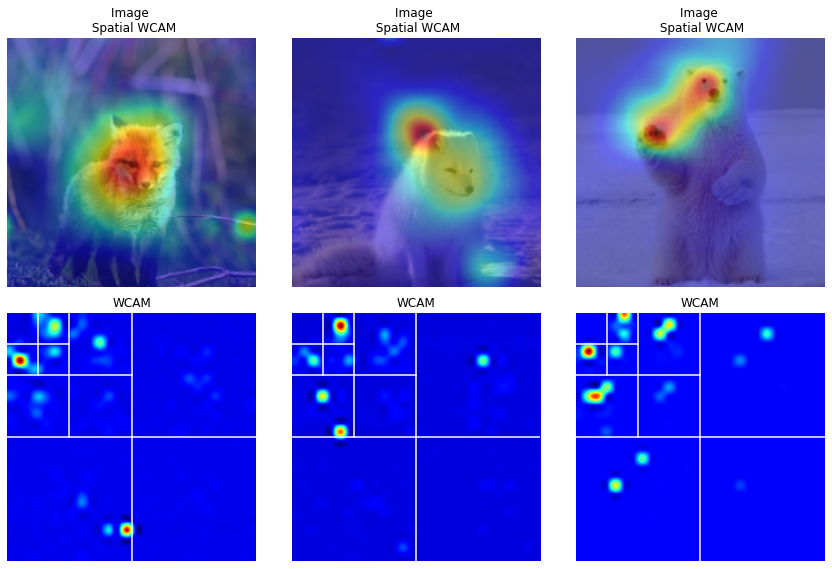

In [19]:
# retrieve the spatial_wcams : 
spatial_wcams = wavelet.spatial_cam

# plot
fig, ax = plt.subplots(2,3, figsize = (12,8))

# setups
size = 224
levels = 3

for i in range(3): # we plot only the three first examples
    
    # plot the image and the spatial wcam
    ax[0,i].imshow(images[i])
    ax[0,i].imshow(spatial_wcams[i], cmap = 'jet', alpha = 0.5)
    ax[0,i].set_title('Image \n Spatial WCAM')

    # on the second row, plot the WCAM and add
    # the lines for a better visualization
    ax[1,i].imshow(explanations[i], cmap = "jet")
    helpers.add_lines(size, levels, ax[1,i])
    ax[1,i].set_title('WCAM')

    # remove the ticks
    ax[0,i].axis('off')
    ax[1,i].axis('off')

fig.tight_layout()
plt.show()

Congratulations ! Now you know how to use the WCAM and can use it in your own projects.

In [20]:
import pywt

def rgb_to_wavelet_array(image, wavelet='haar', level=3):
    # Convert PIL image to NumPy array
    img_array = np.array(image.convert('L'))

    # Compute wavelet transform for each channel
    c = pywt.wavedec2(img_array, wavelet, level=level)     
    # normalize each coefficient array independently for better visibility
    c[0] /= np.abs(c[0]).max()
    for detail_level in range(level):
        c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
    arr, _ = pywt.coeffs_to_array(c)

    
    return arr

def plot_wcam(ax, image, wcam, levels, vmin = None, vmax = None):
    """
    plts the wcam
    """
    size = image.size[0]
    # compute the wavelet transform
    wt = rgb_to_wavelet_array(image,level = levels)
    
    # plots
    ax.imshow(wt, cmap = 'gray')
    im = ax.imshow(wcam, cmap = "hot", alpha = 0.5, vmin = vmin, vmax = vmax)

    ax.axis('off')
    
    helpers.add_lines(size, levels, ax)

    #plt.colorbar(im, ax = ax)

    return None

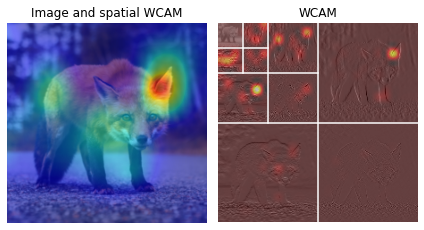

In [36]:
fig, ax = plt.subplots(1,2)

index = 4

ax[0].imshow(images[index])
ax[0].axis('off')
ax[0].imshow(spatial_wcams[index], cmap = 'jet', alpha = 0.5)

plot_wcam(ax[1], images[index], explanations[index], 3)

ax[0].set_title('Image and spatial WCAM')
ax[1].set_title('WCAM')

fig.tight_layout()
plt.savefig('figs/example_wcam.pdf')
plt.show()